In [4]:
from os import rename

import pandas as pd
import numpy as np
import warnings

pd.options.display.max_columns = None
warnings.filterwarnings("ignore")

from google.cloud import bigquery
from google.cloud import bigquery_storage
creds = "/Users/srdeo/OneDrive - Copart, Inc/secrets/cprtpr-datastewards-sp1-614d7e297848 (1).json"
client = bigquery.Client.from_service_account_json(json_credentials_path=creds)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=creds)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Q1. Total number of Premier members in Copart?

In [141]:
query1 = """
select mbr_nbr, owner_mbr_nbr, mbr_country_desc, mbr_mbrshp_type_cd, mbr_status
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
"""

data_members_2025 = client.query(query1).to_dataframe()

In [142]:
data_members_2025.head()
data_members_2025.shape
print(data_members_2025.isnull().sum())
data_members_2025['mbr_mbrshp_type_cd'].value_counts()

,mbr_nbr,owner_mbr_nbr,mbr_country_desc,mbr_mbrshp_type_cd,mbr_status
0,1241569915757772800,1241569915757772800,None,GUEST,None
1,1240848294738911232,1240848294738911232,None,GUEST,None
2,464285,464285,UNITED STATES,GUEST,I
3,1241385582340190208,1241385582340190208,None,GUEST,None
4,1240839219760304128,1240839219760304128,None,GUEST,None


(12560431, 5)

mbr_nbr                      0
owner_mbr_nbr                0
mbr_country_desc       9958820
mbr_mbrshp_type_cd           0
mbr_status            11663855
dtype: int64


mbr_mbrshp_type_cd
GUEST      11722393
BASIC        691271
PREMIER      146767
Name: count, dtype: int64

In [9]:
## Total number of duplicate owner numbers

data_members_2025.duplicated('owner_mbr_nbr').sum()

np.int64(47399)

In [13]:
## Dropping duplicates based on owner_mbr_nbr

data_members_2025_no_duplicates = data_members_2025.drop_duplicates('owner_mbr_nbr')

In [14]:
data_members_2025_no_duplicates['mbr_mbrshp_type_cd'].value_counts()

mbr_mbrshp_type_cd
GUEST      11687683
BASIC        691407
PREMIER      102100
Name: count, dtype: int64

In [19]:
counts = data_members_2025_no_duplicates['mbr_mbrshp_type_cd'].value_counts()
percentages = data_members_2025_no_duplicates['mbr_mbrshp_type_cd'].value_counts(normalize=True) * 100

summary = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages.round(2)
})

summary

,Count,Percentage
mbr_mbrshp_type_cd,,
GUEST,11687683,93.64
BASIC,691407,5.54
PREMIER,102100,0.82


In [17]:
## To check null values in the dataset

data_members_2025_no_duplicates.isnull().sum()

mbr_nbr                      0
owner_mbr_nbr                0
mbr_country_desc       9929716
mbr_mbrshp_type_cd           0
mbr_status            11634936
dtype: int64

In [18]:
data_members_2025_no_duplicates.shape

(12481190, 5)

### Q2. How many Premier members have bought lots in the last 6 months/ 3 months/ 1 month?

In [143]:
query4 = """
select member_sgmnt_type, count(*) as member_count
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
where mbr_mbrshp_type_cd = 'PREMIER'
group by member_sgmnt_type
"""

data_PM_type = client.query(query4).to_dataframe()

In [144]:
data_PM_type.head()
data_PM_type.shape
print(data_PM_type.isnull().sum())

,member_sgmnt_type,member_count
0,None,5574
1,Dismantler,28850
2,General Business,3728
3,Dealer,33687
4,Consumer,45582


(6, 2)

member_sgmnt_type    1
member_count         0
dtype: int64


In [23]:
## Check duplicates in owner_mbr_nbr

data_premier_buying_6months['owner_mbr_nbr'].duplicated().sum()

np.int64(1785707)

In [24]:
data_premier_buying_6months = data_premier_buying_6months.drop_duplicates(['owner_mbr_nbr'])

In [25]:
data_premier_buying_6months['mbr_nbr'].nunique()

55263

In [26]:
## Extracting month from the invoice date

data_premier_buying_6months['inv_dt'] = pd.to_datetime(data_premier_buying_6months['inv_dt'])
data_premier_buying_6months['inv_dt_month'] = data_premier_buying_6months['inv_dt'].dt.month

data_premier_buying_6months

,lot_nbr,buyer_nbr,mbr_nbr,owner_mbr_nbr,mbr_status,mbr_country_desc,inv_dt,acv,high_bid_amt,inv_dt_month
0,45928735,248618,248618,248618,A,UNITED STATES,2025-02-23,0.00,10500.0,2
1,80509744,6915,6915,6915,A,UNITED STATES,2025-01-26,0.00,550.0,1
2,53283265,31666,31666,31666,A,"GHANA,REPUBLIC OF",2025-05-24,24922.00,5700.0,5
3,59498104,129396,129396,484427,I,UNITED ARAB EMIRATES,2024-12-29,22440.00,4200.0,12
4,69954044,495671,495671,495671,A,MAURITANIA,2024-12-07,20450.40,5500.0,12
...,...,...,...,...,...,...,...,...,...,...
1840703,53085165,137291,137291,137291,I,UNITED STATES,2025-06-10,25884.89,14900.0,6
1840854,45089285,147562,147562,147562,A,UNITED STATES,2025-06-10,9732.00,3250.0,6
1840858,42251735,486977,486977,486977,A,UNITED STATES,2025-06-10,2665.00,1750.0,6
1840862,58442385,746062,746062,746062,A,CANADA,2025-06-10,25319.14,16200.0,6


In [27]:
## Dividing the data into different month groups

data_premier_buying_6months_Dec_to_May = data_premier_buying_6months[data_premier_buying_6months['inv_dt_month'].isin([12, 1, 2, 3, 4, 5])]
data_premier_buying_6months_May = data_premier_buying_6months[data_premier_buying_6months['inv_dt_month'] == 5]
data_premier_buying_6months_March_to_May = data_premier_buying_6months[data_premier_buying_6months['inv_dt_month'].isin([3, 4, 5])]

In [29]:
data_premier_buying_6months_Dec_to_May['owner_mbr_nbr'].nunique()

52848

In [30]:
data_premier_buying_6months_March_to_May['owner_mbr_nbr'].nunique()

16817

In [31]:
data_premier_buying_6months_May['owner_mbr_nbr'].nunique()

5031

### Q3. What is the distribution of ACV and Selling Price for lots bought by Premier members in the last 6 months?

<Axes: title={'center': 'ACV Distribution'}, ylabel='Frequency'>

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

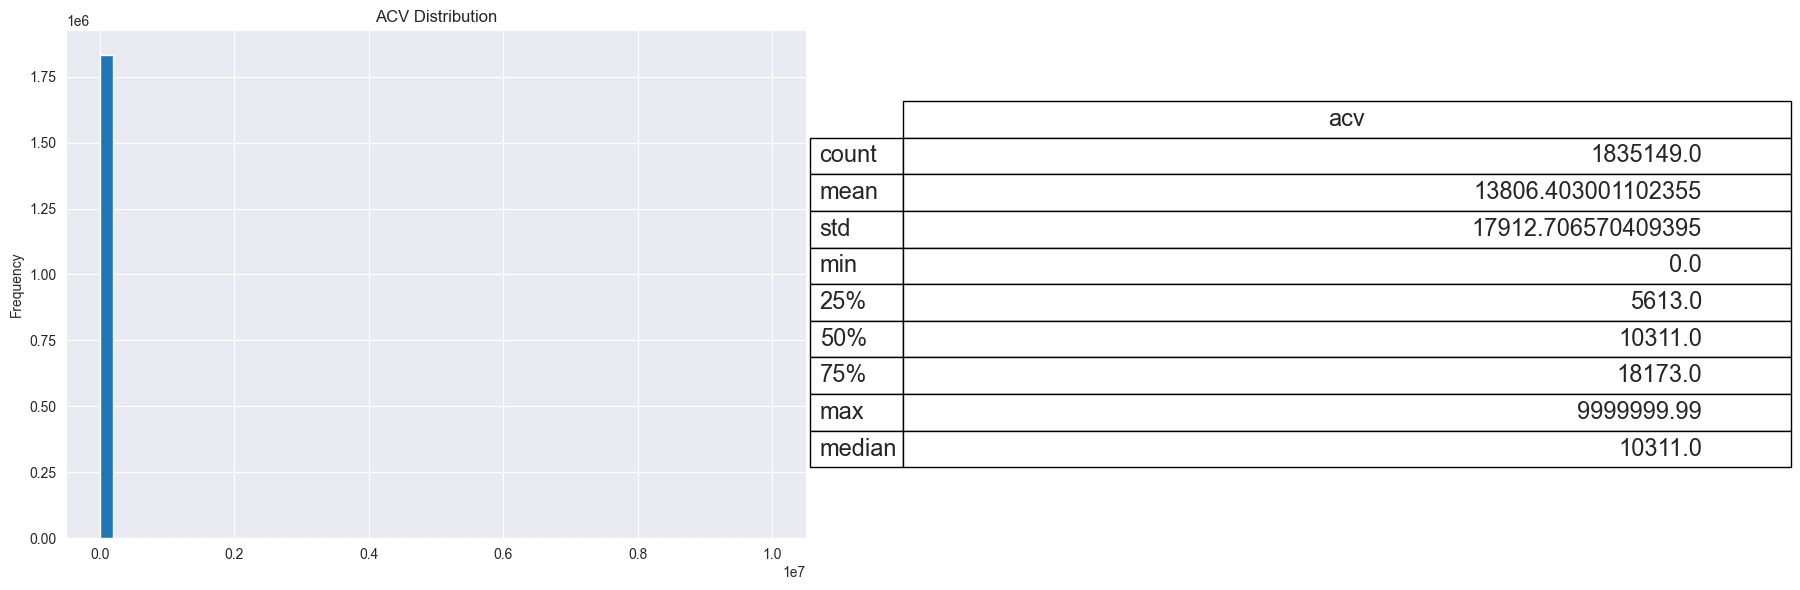

In [129]:
## ACV Distribution and Outliers

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram
data_premier_buying_6months['acv'].plot(
    kind='hist', bins=50, ax=axes[0], title='ACV Distribution'
)

# Describe table
desc = data_premier_buying_6months['acv'].describe().to_frame()
desc.loc['median'] = data_premier_buying_6months['acv'].median()
axes[1].axis('off')
table = axes[1].table(
    cellText=desc.values,
    rowLabels=desc.index,
    colLabels=['acv'],
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(17)
table.scale(1.2,2)

plt.tight_layout()
plt.show()

#### * Checking for outliers in ACV

In [130]:
data_premier_buying_6months[data_premier_buying_6months['acv']==0]

,lot_nbr,buyer_nbr,mbr_nbr,owner_mbr_nbr,mbr_country_desc,mbr_status,inv_dt,acv,high_bid_amt,inv_dt_month
9,53718995,909921,909921,909921,UNITED STATES,A,2025-05-26,0.0,1600.0,5
14,80587454,244151,244151,220834,UNITED STATES,A,2024-12-14,0.0,104000.0,12
15,47804385,339109,339109,339109,UNITED STATES,A,2025-04-12,0.0,500.0,4
16,41569545,383732,383732,383732,UNITED STATES,A,2025-05-11,0.0,500.0,5
33,51361905,524325,524325,524325,UNITED STATES,A,2025-04-20,0.0,300.0,4
...,...,...,...,...,...,...,...,...,...,...
1835094,50359625,420688,420688,420688,UNITED STATES,A,2025-06-10,0.0,7500.0,6
1835102,58924975,200283,200283,200283,UNITED ARAB EMIRATES,A,2025-06-10,0.0,500.0,6
1835128,59606095,895668,895668,688783,UNITED STATES,A,2025-06-10,0.0,700.0,6
1835129,54176125,519058,519058,519058,UNITED STATES,A,2025-06-10,0.0,1050.0,6


In [131]:
data_premier_buying_6months[data_premier_buying_6months['acv']==9999999.99]

,lot_nbr,buyer_nbr,mbr_nbr,owner_mbr_nbr,mbr_country_desc,mbr_status,inv_dt,acv,high_bid_amt,inv_dt_month
1678425,57888305,583968,583968,583968,UNITED STATES,A,2025-05-22,9999999.99,10900.0,5
1759674,56763685,8917,8917,8917,UNITED STATES,A,2025-06-02,9999999.99,1600.0,6


<Axes: title={'center': 'Selling Price Distribution'}, ylabel='Frequency'>

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

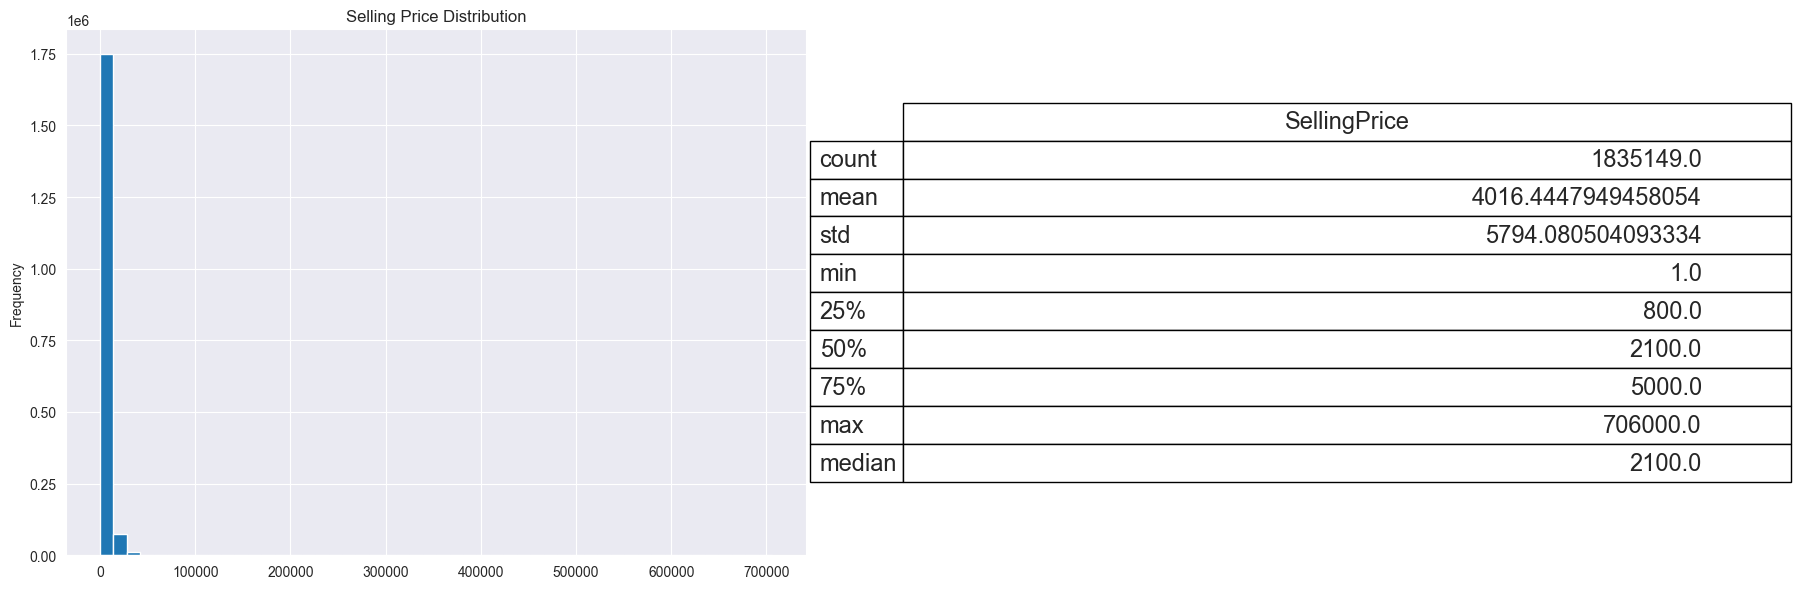

In [132]:
## Selling Price Distribution and Outliers

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram
data_premier_buying_6months['high_bid_amt'].plot(
    kind='hist', bins=50, ax=axes[0], title='Selling Price Distribution'
)

# Describe table
desc = data_premier_buying_6months['high_bid_amt'].describe().to_frame()
desc.loc['median'] = data_premier_buying_6months['high_bid_amt'].median()
axes[1].axis('off')
table = axes[1].table(
    cellText=desc.values,
    rowLabels=desc.index,
    colLabels=['SellingPrice'],
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(17)
table.scale(1.2,2)

plt.tight_layout()
plt.show()

#### * Checking for outliers in Selling Price

In [133]:
data_premier_buying_6months[data_premier_buying_6months['high_bid_amt']==706000]

,lot_nbr,buyer_nbr,mbr_nbr,owner_mbr_nbr,mbr_country_desc,mbr_status,inv_dt,acv,high_bid_amt,inv_dt_month
823676,79169614,580261,580261,580261,UNITED STATES,A,2025-02-24,1624907.0,706000.0,2


In [134]:
data_premier_buying_6months[data_premier_buying_6months['high_bid_amt']==1]

,lot_nbr,buyer_nbr,mbr_nbr,owner_mbr_nbr,mbr_country_desc,mbr_status,inv_dt,acv,high_bid_amt,inv_dt_month
34296,75170834,110743,110743,110743,UNITED STATES,A,2024-12-02,7841.00,1.0,12
37938,72533774,110743,110743,110743,UNITED STATES,A,2024-12-02,29815.00,1.0,12
39174,77695244,110743,110743,110743,UNITED STATES,A,2024-12-02,25415.00,1.0,12
45560,63278724,110743,110743,110743,UNITED STATES,A,2024-12-03,21801.00,1.0,12
66308,73007674,49996,49996,49996,UNITED STATES,A,2024-12-04,12859.00,1.0,12
...,...,...,...,...,...,...,...,...,...,...
1810687,42826995,49996,49996,49996,UNITED STATES,A,2025-06-09,9946.00,1.0,6
1813113,51479655,69595,69595,69595,UNITED STATES,A,2025-06-09,24650.00,1.0,6
1820213,56182192,303188,303188,303188,UNITED STATES,A,2025-06-09,1.00,1.0,6
1821496,52606475,69595,69595,69595,UNITED STATES,A,2025-06-09,8983.00,1.0,6


### Q4. Total number of unique PMs who placed a bid (on the lots sold) in the last month, last 3 months and last 6 months

In [3]:
query3 = """
select b.owner_mbr_nbr, a.buyer_nbr, a.lot_nbr, c.inv_dt
from `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact a
    join `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact b
    on a.buyer_nbr = b.mbr_nbr
    join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact c
    on a.lot_nbr = c.lot_nbr
where c.inv_dt >= '2024-12-01'
    and mbr_mbrshp_type_cd in ('PREMIER')
"""

data_PMs_bids_lotssold_6months = client.query(query3).to_dataframe()

In [4]:
data_PMs_bids_lotssold_6months

,owner_mbr_nbr,buyer_nbr,lot_nbr,inv_dt
0,100053,100053,82559854,2024-12-14
1,834146,834146,82559854,2024-12-14
2,100053,100053,82557504,2024-12-14
3,967608,967608,82556094,2024-12-25
4,967608,967608,82556094,2024-12-25
...,...,...,...,...
84294321,251438,251438,53139255,2025-06-10
84294322,531689,596921,53137875,2025-06-10
84294323,572858,572858,53123905,2025-06-10
84294324,893317,893317,53138135,2025-06-10


In [5]:
data_PMs_bids_lotssold_6months.shape

(84294326, 4)

In [6]:
data_PMs_bids_lotssold_6months['owner_mbr_nbr'].duplicated().sum()

np.int64(84221692)

In [7]:
data_PMs_bids_lotssold_6months = data_PMs_bids_lotssold_6months.drop_duplicates(['owner_mbr_nbr'])

In [8]:
data_PMs_bids_lotssold_6months['buyer_nbr'].nunique()

72634

In [9]:
data_PMs_bids_lotssold_6months.isnull().sum()

owner_mbr_nbr    0
buyer_nbr        0
lot_nbr          0
inv_dt           0
dtype: int64

In [10]:
## Extracting month from the auction date

data_PMs_bids_lotssold_6months['inv_dt'] = pd.to_datetime(data_PMs_bids_lotssold_6months['inv_dt'])
data_PMs_bids_lotssold_6months['inv_dt_month'] = data_PMs_bids_lotssold_6months['inv_dt'].dt.month

data_PMs_bids_lotssold_6months_Dec_to_May = data_PMs_bids_lotssold_6months[data_PMs_bids_lotssold_6months['inv_dt_month'].isin([12, 1, 2, 3, 4, 5])]
data_PMs_bids_lotssold_6months_May = data_PMs_bids_lotssold_6months[data_PMs_bids_lotssold_6months['inv_dt_month'] == 5]
data_PMs_bids_lotssold_6months_March_to_May = data_PMs_bids_lotssold_6months[data_PMs_bids_lotssold_6months['inv_dt_month'].isin([3, 4, 5])]

In [11]:
data_PMs_bids_lotssold_6months

,owner_mbr_nbr,buyer_nbr,lot_nbr,inv_dt,inv_dt_month
0,100053,100053,82559854,2024-12-14,12
1,834146,834146,82559854,2024-12-14,12
3,967608,967608,82556094,2024-12-25,12
5,357817,357817,82598024,2024-12-22,12
6,638766,638766,82559854,2024-12-14,12
...,...,...,...,...,...
84200052,625025,625025,51410563,2025-06-10,6
84217506,36749,36749,53993845,2025-06-10,6
84225263,628768,628768,46293515,2025-06-10,6
84261345,573668,573668,53729635,2025-06-10,6


In [15]:
data_PMs_bids_lotssold_6months_Dec_to_May['buyer_nbr'].nunique()

68380

In [17]:
data_PMs_bids_lotssold_6months_March_to_May['buyer_nbr'].nunique()

24504

In [18]:
data_PMs_bids_lotssold_6months_May['buyer_nbr'].nunique()

8182

<Axes: title={'center': 'Monthly Distribution of Sold Lots in US (2025) for Premier Members'}, xlabel='inv_dt_month'>

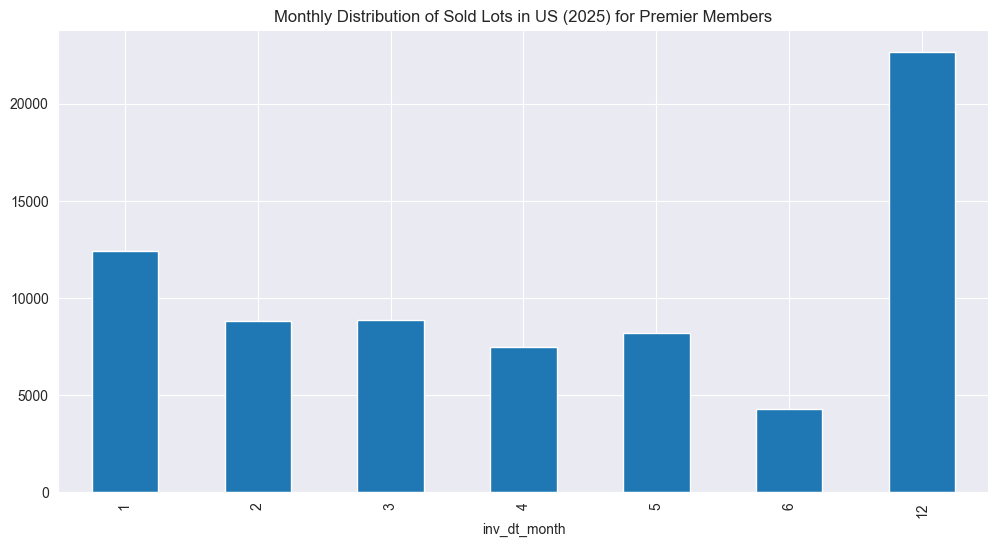

In [32]:
data_PMs_bids_lotssold_6months['inv_dt_month'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), title='Monthly Distribution of Sold Lots in US (2025) for Premier Members')

### Q5. What is the category that Premier members fall into? Dismantler, Dealer etc?

In [3]:
query4 = """
select member_sgmnt_type, count(distinct owner_mbr_nbr) as member_count
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
where mbr_mbrshp_type_cd = 'PREMIER'
group by member_sgmnt_type
"""

data_PM_type = client.query(query4).to_dataframe()

In [4]:
data_PM_type

,member_sgmnt_type,member_count
0,Exporter,21541
1,General Business,3640
2,None,4125
3,Consumer,45356
4,Dismantler,6491
5,Dealer,23202


### Q6. Where are the Premier members located? Top 10 countries and volume(lots sold) in the last 6 months

In [169]:
query5 = """
select mbr_country_desc, count(distinct owner_mbr_nbr) as member_count, count(distinct lot_nbr) as lots_bought
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
on m.owner_mbr_nbr = l.owner_buyer_nbr
where mbr_mbrshp_type_cd = 'PREMIER' and inv_dt between '2024-12-01' and '2025-05-31'
group by mbr_country_desc
"""

data_PM_country = client.query(query5).to_dataframe()

In [170]:
data_PM_country

,mbr_country_desc,member_count,lots_bought
0,SOUTH KOREA,8,52
1,MACEDONIA,1,2
2,VENEZUELA,7,91
3,KYRGYZSTAN,2,75
4,BENIN,34,1594
...,...,...,...
117,BAHRAIN,3,4
118,ARGENTINA,1,1
119,COSTA RICA,79,2332
120,NICARAGUA,9,164


In [172]:
top10_countries = data_PM_country.nlargest(10, 'member_count')
top10_countries

,mbr_country_desc,member_count,lots_bought
43,UNITED STATES,39938,1173155
27,MEXICO,3538,146588
77,CANADA,2310,32289
14,GUATEMALA,1924,34841
18,NIGERIA,1256,34218
24,EL SALVADOR,1001,23510
23,HONDURAS,808,23821
74,UNITED ARAB EMIRATES,435,65592
31,"GHANA,REPUBLIC OF",339,5685
63,GEORGIA,288,75540


### Q7. Find count of members who placed bids on lots sold in the last 6 months but did not buy any lots?

Steps -

1. Join member_fact to bids_fact to get only Premier members

2. Join bids_fact from above to lot_fact on lot number and filter on lots with inv_dt between Dec 2024 – May 2025

3. This gives us the total bids placed on lots sold in 6 months

4. Count distinct owner mbr nbr

5. Join member fact to lot fact to get count of PMs who win in the last 6 months

6. Subtract the two numbers to get count of PMs who placed a bid on the lots sold in 6 months but did not win

In [163]:
query6 = """
select count(distinct m.owner_mbr_nbr)
from `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
join `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
on buyer_nbr = mbr_nbr
join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
on b.lot_nbr = l.lot_nbr
where inv_dt is not null and inv_dt between '2024-12-01' and '2025-05-31'  --- to include only lots sold in the last 6 months
and m.mbr_mbrshp_type_cd = 'PREMIER' --- to include only Premier members
"""

data_PMs = client.query(query6).to_dataframe()

In [223]:
print("Total PMs who placed a bid on the lots sold in the last 6 months: ", data_PMs['f0_'].values[0])

Total PMs who placed a bid on the lots sold in the last 6 months:  71329


In [227]:
query61 = """
select count(distinct m.owner_mbr_nbr)
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
on m.owner_mbr_nbr = l.owner_buyer_nbr
where inv_dt is not null and inv_dt between '2024-12-01' and '2025-05-31'  --- to include only lots sold in the last 6 months
and m.mbr_mbrshp_type_cd = 'PREMIER' --- to include only Premier members
"""

data_PMs_win = client.query(query61).to_dataframe()

In [228]:
print("Total PMs who won the lots sold in the last 6 months: ", data_PMs_win['f0_'].values[0])

Total PMs who won the lots sold in the last 6 months:  54097


In [231]:
query62 = """
select count(distinct m.owner_mbr_nbr)
from `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
join `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
on buyer_nbr = mbr_nbr
join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
on b.lot_nbr = l.lot_nbr
where inv_dt is not null and inv_dt between '2024-12-01' and '2025-05-31'  --- to include only lots sold in the last 6 months
and m.mbr_mbrshp_type_cd = 'PREMIER' --- to include only Premier members
and owner_mbr_nbr not in (select distinct m.owner_mbr_nbr
from `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
on m.owner_mbr_nbr = l.owner_buyer_nbr
where inv_dt is not null and inv_dt between '2024-12-01' and '2025-05-31'  --- to include only lots sold in the last 6 months
and m.mbr_mbrshp_type_cd = 'PREMIER' )
"""

data_PMs_bids_no_wins = client.query(query62).to_dataframe()

In [232]:
print("Total PMs who won the lots sold in the last 6 months: ", data_PMs_bids_no_wins['f0_'].values[0])

Total PMs who won the lots sold in the last 6 months:  17247


### Q8. Find member win %? Definition- # of PMs bought at least 1 lot/(# of PMs who placed at least one bid). Do this month over month over last 12 months for lots sold

Steps -

* Numerator:

1. Join member_fact to lot_fact to get list of PMs who won lots

2. Filter on lots sold between June 2024 – May 2025

3. Group by month from inv_dt and count distinct PMs

In [186]:
## People who won lots in the last 12 months, month by month

query7 = """
select extract(month from inv_dt) as month, count(distinct m.owner_mbr_nbr)
from `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
join `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
on l.owner_buyer_nbr = m.owner_mbr_nbr
where mbr_mbrshp_type_cd = 'PREMIER'  --- to include only Premier members
and inv_dt is not null and inv_dt between '2024-06-01' and '2025-05-31'  --- to include only lots sold in the last 12 months
    group by month
"""

data_PMs_won_in_one_year = client.query(query7).to_dataframe()

In [187]:
data_PMs_won_in_one_year

,month,f0_
0,1,28488
1,9,26535
2,7,24725
3,6,23271
4,5,28433
5,3,29685
6,2,28351
7,11,27057
8,12,27353
9,8,26284


Steps -

* Denominator:

1. Join bids_fact to member_fact to get all PMs who placed a bid

2. Join the above with lot_fact on lot number to get bids that were placed on lots sold

3. Filter on lots sold between June 2024 – May 2025

4. Group by month from inv_dt and count distinct PMs

In [193]:
## People who placed bids on the winning lots in the last 12 months, month by month

query8 = """
select extract(month from inv_dt) as month, count(distinct m.owner_mbr_nbr)
from `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
join `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
on buyer_nbr = mbr_nbr
join `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
on b.lot_nbr = l.lot_nbr  ---  to get winning lots
where inv_dt is not null and inv_dt between '2024-06-01' and '2025-05-31'   --- to include only lots sold in the last 12 months
and m.mbr_mbrshp_type_cd = 'PREMIER'  --- to include only Premier members
    group by month
"""

data_PMs_bids_in_one_year = client.query(query8).to_dataframe()

In [194]:
data_PMs_bids_in_one_year

,month,f0_
0,1,45202
1,5,46429
2,4,47802
3,9,40421
4,3,47034
5,12,43037
6,7,37053
7,2,45382
8,6,34853
9,11,42043


* Merging numerator and denominator on month

In [198]:
abc = pd.merge(data_PMs_won_in_one_year, data_PMs_bids_in_one_year, on='month', how='inner')
abc.rename(columns={'f0__x': 'bids_won', 'f0__y':'bids placed'}, inplace=True)

In [199]:
abc

,month,bids_won,bids placed
0,1,28488,45202
1,9,26535,40421
2,7,24725,37053
3,6,23271,34853
4,5,28433,46429
5,3,29685,47034
6,2,28351,45382
7,11,27057,42043
8,12,27353,43037
9,8,26284,39332


* Calculating win %

In [200]:
abc['winning_perc'] = round((abc['bids_won'] / abc['bids placed']) * 100, 2)
abc

,month,bids_won,bids placed,winning_perc
0,1,28488,45202,63.02
1,9,26535,40421,65.65
2,7,24725,37053,66.73
3,6,23271,34853,66.77
4,5,28433,46429,61.24
5,3,29685,47034,63.11
6,2,28351,45382,62.47
7,11,27057,42043,64.36
8,12,27353,43037,63.56
9,8,26284,39332,66.83


### Q9. Out of the 17k PMs who bid but did not win in the last 6 months:

* 1. Divide them into 3 buckets: bid less than 5 lots, between 5-10 lots, greater than 10 lots

In [233]:
query9 = """
WITH winners AS --- winning PMs in the last 6 months
         (
  SELECT DISTINCT m.owner_mbr_nbr
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON m.owner_mbr_nbr = l.owner_buyer_nbr
  WHERE l.inv_dt IS NOT NULL
    AND l.inv_dt BETWEEN '2024-12-01' AND '2025-05-31'
    AND m.mbr_mbrshp_type_cd = 'PREMIER'
)
SELECT
  m.owner_mbr_nbr,
  l.lot_nbr,
  m.member_sgmnt_type,
  m.mbr_country_desc
FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  ON b.buyer_nbr = m.mbr_nbr
JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
  ON b.lot_nbr = l.lot_nbr
WHERE l.inv_dt IS NOT NULL
  AND l.inv_dt BETWEEN '2024-12-01' AND '2025-05-31'
  AND m.mbr_mbrshp_type_cd = 'PREMIER'
  AND m.owner_mbr_nbr NOT IN  --- exclude winning PMs from all to get losing PMs
      (SELECT owner_mbr_nbr FROM winners)
"""

data_PMs_lots_bid_no_win_6months = client.query(query9).to_dataframe()

In [234]:
data_PMs_lots_bid_no_win_6months

,owner_mbr_nbr,lot_nbr,member_sgmnt_type,mbr_country_desc
0,408273,45671135,Consumer,UNITED STATES
1,65348,69409604,Dealer,UNITED STATES
2,307772,45602105,Consumer,UNITED STATES
3,7017,72953774,Consumer,UNITED STATES
4,664158,44569975,Consumer,UNITED STATES
...,...,...,...,...
1860660,909615,52255915,Dealer,UNITED STATES
1860661,909615,52713945,Dealer,UNITED STATES
1860662,909615,50518435,Dealer,UNITED STATES
1860663,909615,50518435,Dealer,UNITED STATES


In [253]:
abc = data_PMs_lots_bid_no_win_6months.groupby('owner_mbr_nbr')['lot_nbr'].nunique()
abc_df = abc.reset_index().rename(columns={'lot_nbr': 'unique_lots_bid'})

In [254]:
abc_df

,owner_mbr_nbr,unique_lots_bid
0,41,4
1,255,15
2,311,2
3,314,2
4,452,3
...,...,...
17242,996200,40
17243,997061,8
17244,999222,4
17245,999489,21


In [256]:
## Diving the data into 3 buckets based on the number of lots bid

bins = [0, 5, 11, float('inf')]
labels = ['<5', '5-10', '>10']

abc_df['lot_bin'] = pd.cut(
    abc_df['unique_lots_bid'], bins=bins, right=False, labels=labels
)

bin_counts = abc_df['lot_bin'].value_counts().sort_index()
print(bin_counts)

lot_bin
<5      10167
5-10     3547
>10      3533
Name: count, dtype: int64


[Text(0, 0, '<5'), Text(1, 0, '5-10'), Text(2, 0, '>10')]

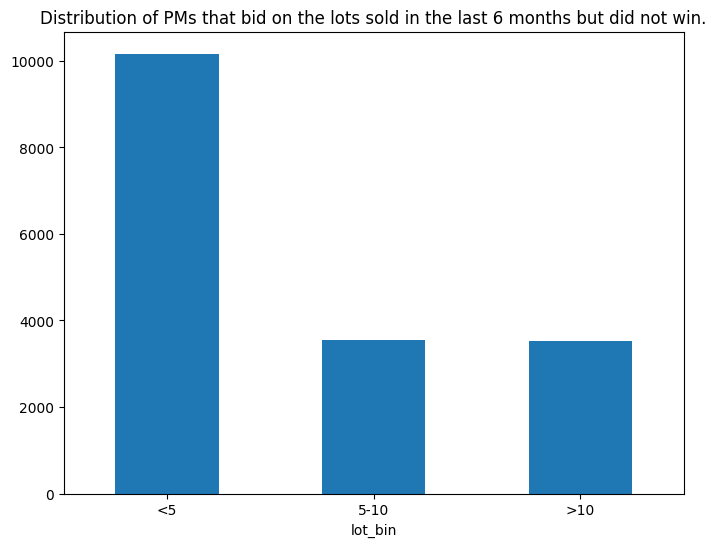

In [257]:
ax = bin_counts.plot(
    kind='bar', figsize=(8, 6), title='Distribution of PMs that bid on the lots sold in the last 6 months but did not win.')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

* 2. Distribution over segment type of 17k PMs

In [240]:
data_PMs_lots_bid_no_win_6months.groupby('member_sgmnt_type')['owner_mbr_nbr'].nunique().sort_values(ascending=False)

member_sgmnt_type
Consumer            10349
Dealer               2843
Exporter             2799
General Business      718
Dismantler            505
Name: owner_mbr_nbr, dtype: int64

[Text(0, 0, 'Consumer'),
 Text(1, 0, 'Dealer'),
 Text(2, 0, 'Exporter'),
 Text(3, 0, 'General Business'),
 Text(4, 0, 'Dismantler')]

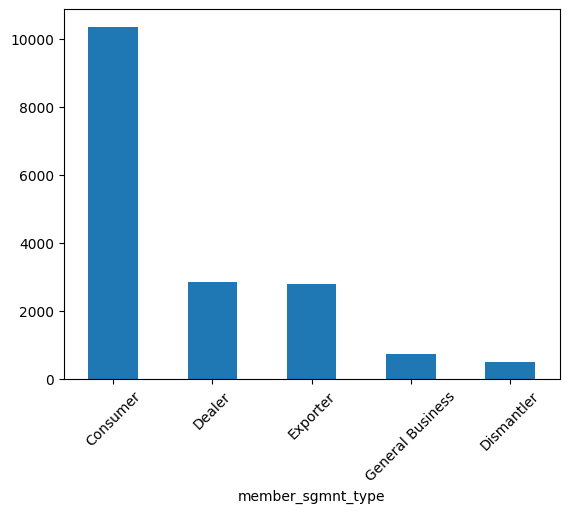

In [244]:
ax = data_PMs_lots_bid_no_win_6months.groupby('member_sgmnt_type')['owner_mbr_nbr'].nunique().sort_values(ascending=False).plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

* 3. Distribution of segment type over segment type of 17k PMs

In [265]:
import pandas as pd

# Step 1: Count unique lots per member within segment
abc = data_PMs_lots_bid_no_win_6months.groupby(['member_sgmnt_type', 'owner_mbr_nbr'])['lot_nbr'].nunique().reset_index()
abc.rename(columns={'lot_nbr': 'unique_lots_bid'}, inplace=True)

# Step 2: Bin each member based on their bid count
bins = [0, 5, 10, float('inf')]
labels = ['<5', '5-10', '>10']
abc['lot_bin'] = pd.cut(abc['unique_lots_bid'], bins=bins, labels=labels, right=True)

# Step 3: Count members in each bin per segment type
result = abc.groupby(['member_sgmnt_type', 'lot_bin']).size().reset_index(name='member_count')

print(result)


   member_sgmnt_type lot_bin  member_count
0           Consumer      <5          6692
1           Consumer    5-10          1541
2           Consumer     >10          2116
3             Dealer      <5          1890
4             Dealer    5-10           460
5             Dealer     >10           493
6         Dismantler      <5           335
7         Dismantler    5-10            64
8         Dismantler     >10           106
9           Exporter      <5          1692
10          Exporter    5-10           445
11          Exporter     >10           662
12  General Business      <5           483
13  General Business    5-10           111
14  General Business     >10           124


<Axes: xlabel='bid_bucket'>

Text(0.5, 1.0, 'Segment: Consumer')

Text(0.5, 0, 'Bid Count Bucket')

Text(0, 0.5, 'Member Count')

<Axes: xlabel='bid_bucket'>

Text(0.5, 1.0, 'Segment: Dealer')

Text(0.5, 0, 'Bid Count Bucket')

Text(0, 0.5, 'Member Count')

<Axes: xlabel='bid_bucket'>

Text(0.5, 1.0, 'Segment: Dismantler')

Text(0.5, 0, 'Bid Count Bucket')

Text(0, 0.5, 'Member Count')

<Axes: xlabel='bid_bucket'>

Text(0.5, 1.0, 'Segment: Exporter')

Text(0.5, 0, 'Bid Count Bucket')

Text(0, 0.5, 'Member Count')

<Axes: xlabel='bid_bucket'>

Text(0.5, 1.0, 'Segment: General Business')

Text(0.5, 0, 'Bid Count Bucket')

Text(0, 0.5, 'Member Count')

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

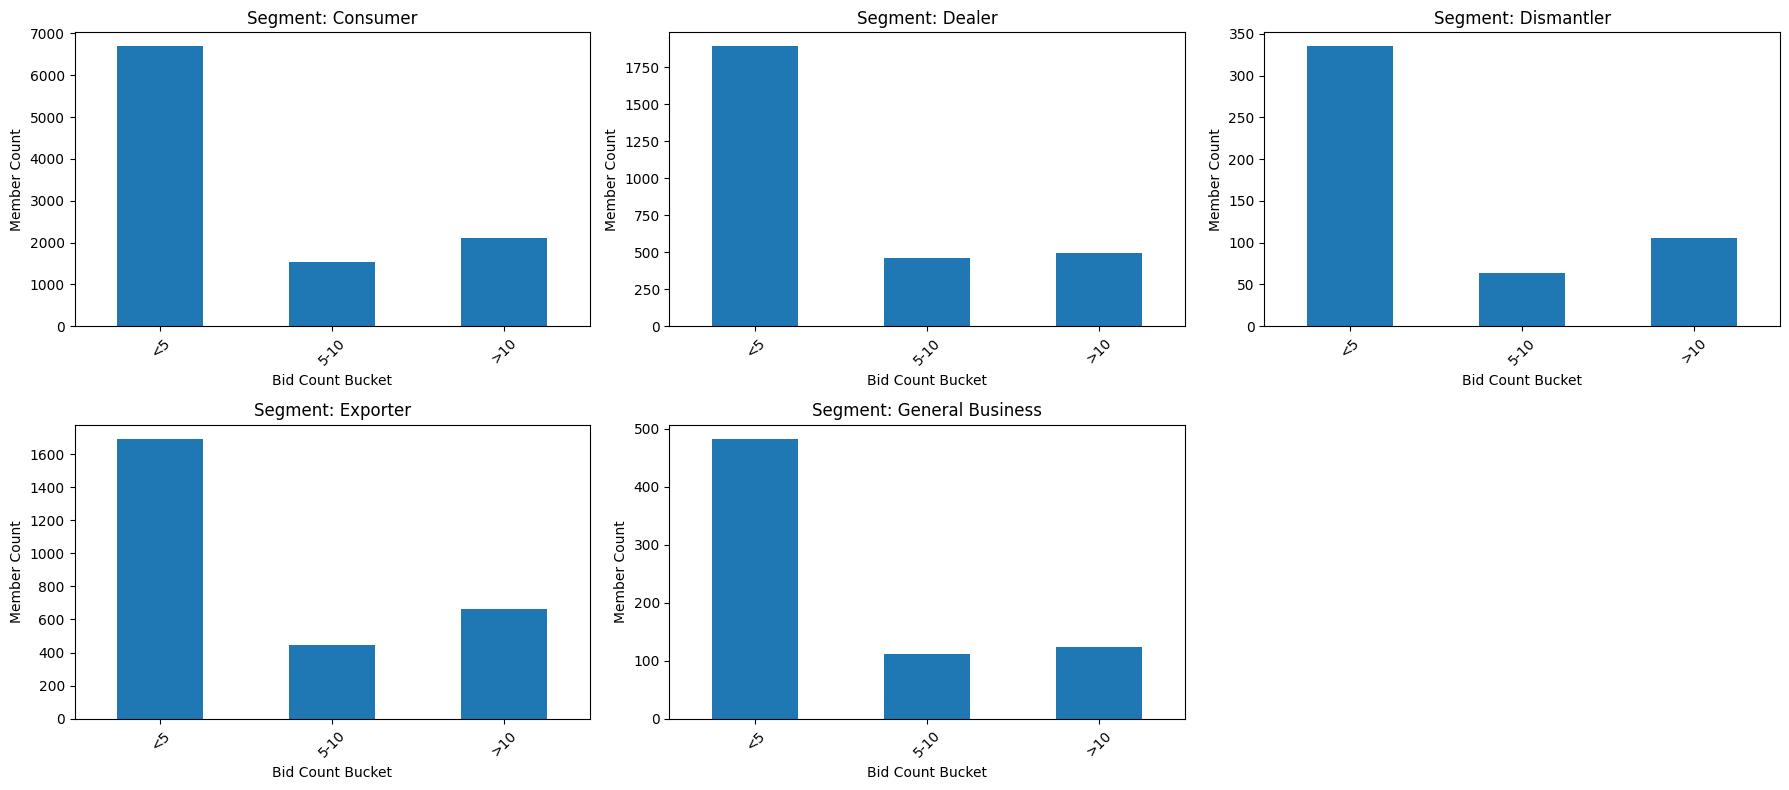

In [276]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Group by member and count unique lots bid
abc = data_PMs_lots_bid_no_win_6months.groupby(['owner_mbr_nbr', 'member_sgmnt_type'])['lot_nbr'].nunique().reset_index()
abc.rename(columns={'lot_nbr': 'unique_lots_bid'}, inplace=True)

# Step 2: Bin the bid counts
bins = [0, 5, 10, float('inf')]
labels = ['<5', '5-10', '>10']
abc['bid_bucket'] = pd.cut(abc['unique_lots_bid'], bins=bins, labels=labels, right=True)

# Step 3: Group by segment and bid bucket
grouped = abc.groupby(['member_sgmnt_type', 'bid_bucket']).size().unstack(fill_value=0)

# Step 4: Plot 3 + 2 layout
segments = grouped.index.tolist()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))  # 2 rows, 3 columns

for i, segment in enumerate(segments):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    grouped.loc[segment].plot(kind='bar', ax=ax)
    ax.set_title(f'Segment: {segment}')
    ax.set_xlabel('Bid Count Bucket')
    ax.set_ylabel('Member Count')
    ax.tick_params(axis='x', rotation=45)

# Turn off the unused 6th plot (bottom-right)
if len(segments) < 6:
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

* 4. Distribution over country of 17k PMs

In [262]:
data_PMs_lots_bid_no_win_6months.groupby('mbr_country_desc')['owner_mbr_nbr'].nunique().sort_values(ascending=False).head(10)

mbr_country_desc
UNITED STATES           14449
CANADA                    849
MEXICO                    428
NIGERIA                   189
GUATEMALA                 183
UNITED ARAB EMIRATES      158
HONDURAS                   96
GHANA,REPUBLIC OF          80
EL SALVADOR                72
BAHAMAS                    68
Name: owner_mbr_nbr, dtype: int64

In [260]:
data_PMs_lots_bid_no_win_6months['mbr_country_desc'].value_counts(normalize=True).head(10)

mbr_country_desc
UNITED STATES           0.873745
CANADA                  0.036047
MEXICO                  0.013933
UNITED ARAB EMIRATES    0.011989
NIGERIA                 0.011661
BENIN                   0.007146
GUATEMALA               0.005528
GHANA,REPUBLIC OF       0.004895
POLAND                  0.003510
PANAMA                  0.003496
Name: proportion, dtype: float64